In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pyspark.sql.functions import when, col, lower, upper, round, regexp_extract, count, countDistinct
from pyspark.sql.types import DoubleType

from pyspark.ml.classification import LogisticRegression


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
    master("local[*]").\
    appName("classification").\
    getOrCreate()

In [3]:
# cases
case_data = "sa311/case.csv"
df_case = spark.read.csv(case_data, header=True)

dept_data = "sa311/dept.csv"
df_dept = spark.read.csv(dept_data, header=True)


In [4]:
df = df_case.join(df_dept, "dept_division", "left_outer")


In [5]:
df.printSchema()


root
 |-- dept_division: string (nullable = true)
 |-- case_id: string (nullable = true)
 |-- case_opened_date: string (nullable = true)
 |-- case_closed_date: string (nullable = true)
 |-- SLA_due_date: string (nullable = true)
 |-- case_late: string (nullable = true)
 |-- num_days_late: string (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: string (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: string (nullable = true)



### Turn the case_late column to the target column. We want to predict if a case is late or not...
### Some questions we might be thinking about are:
### <li> Does the type of department effect if a case is late or not?
### <li> Does the location of the request effect if a case is late or not?
### <li> Does any feature effect if a case is late or not?

In [6]:
df = df.select(lower(col('dept_division')).alias('dept_division'), 
          lower(col('service_request_type')).alias('request_type'),
          lower(col('dept_name')).alias('dept_name'),
          lower(col('standardized_dept_name')).alias('dept_name_std'),
          (col('case_closed')=='YES').alias('case_closed'),
          when(col('case_late')=='YES', 1).otherwise(0).alias('target'),
          (col('dept_subject_to_SLA')=='YES').alias('dept_w_SLA'),
          round(col('num_days_late').cast(DoubleType()), 2).alias('days_late'),
          round(col('SLA_days').cast(DoubleType()), 2).alias('SLA_days'),
          regexp_extract(col('request_address'),"(\d{5})$", 1).\
               alias("request_address_zip")
         )


### We can drop the department name column because it is redundant

In [7]:
df.select(countDistinct('dept_division'), 
          countDistinct('dept_name'),
          countDistinct('dept_name_std'),
          countDistinct('request_type')).\
          toPandas().transpose()

,0
count(DISTINCT dept_division),39
count(DISTINCT dept_name),9
count(DISTINCT dept_name_std),8
count(DISTINCT request_type),334


In [8]:
df = df.drop('dept_name')


### Filter out the entries that are closed cases. We don't care about these...

In [9]:
from pyspark.ml.feature import SQLTransformer

filterer = SQLTransformer(
    statement="SELECT * FROM __THIS__ WHERE \
           dept_w_SLA AND case_closed")

filtered = filterer.transform(df)

In [10]:
filtered.\
    groupBy('target').\
    count().orderBy('target').show()

+------+------+
|target| count|
+------+------+
|     0|735612|
|     1| 87978|
+------+------+



In [11]:
filtered.printSchema()


root
 |-- dept_division: string (nullable = true)
 |-- request_type: string (nullable = true)
 |-- dept_name_std: string (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- target: integer (nullable = false)
 |-- dept_w_SLA: boolean (nullable = true)
 |-- days_late: double (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- request_address_zip: string (nullable = true)



### Create a function to explore the features we can use to answer the question, What predicts if a case is late or not?...

In [12]:
def explore(df, target, cont1, cont2):
    from pyspark.sql.functions import count, mean, corr
    aggregated = df.groupby(target).agg(count(cont1), 
                                      mean(cont1),
                                      mean(cont2),
                                      corr(cont1,cont2)
                                     ).orderBy(target)
    aggregated.show()

In [13]:
explore(filtered, 'target','SLA_days','days_late')


+------+---------------+------------------+------------------+-------------------------+
|target|count(SLA_days)|     avg(SLA_days)|    avg(days_late)|corr(SLA_days, days_late)|
+------+---------------+------------------+------------------+-------------------------+
|     0|         735612| 64.44108282627009|-58.57142732854887|       -0.997626452823121|
|     1|          87978|14.202606674396014|22.111734751869776|      0.24758733973851155|
+------+---------------+------------------+------------------+-------------------------+



### Takeaway: the cases that are past their due date seem to have shorter SLA's


# Put some selected features into a dataframe in order to perform modeling.

# Start with SLA_days and days_late

In [14]:
sample_pdf = filtered.select('SLA_days', 'days_late', 'target'). \
  sample(False, 0.20, 12345). \
  toPandas()

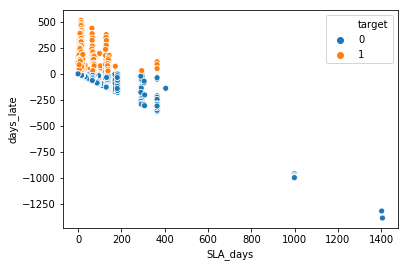

In [15]:
sns.scatterplot(x=sample_pdf.SLA_days, 
                y=sample_pdf.days_late,
                hue=sample_pdf.target
               )

plt.show()

### Encode the Dept_name_std column to numeric

In [16]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="dept_name_std", outputCol="dept_name_std_ix")
indexer_model = indexer.fit(filtered)
list(enumerate(indexer_model.labels))
indexed = indexer_model.transform(filtered)
indexed.select("dept_name_std", "dept_name_std_ix").show(5)

+--------------------+----------------+
|       dept_name_std|dept_name_std_ix|
+--------------------+----------------+
|animal care services|             2.0|
|trans & cap impro...|             3.0|
|trans & cap impro...|             3.0|
|dsd/code enforcement|             0.0|
|animal care services|             2.0|
+--------------------+----------------+
only showing top 5 rows



### Turn a dataframe into a format that can be processed in a model.

In [17]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol="dept_name_std_ix", outputCol="dept_name_std_cd")
encoded = encoder.transform(indexed)
encoded.select("dept_name_std", "dept_name_std_ix", "dept_name_std_cd").show(5)

+--------------------+----------------+----------------+
|       dept_name_std|dept_name_std_ix|dept_name_std_cd|
+--------------------+----------------+----------------+
|animal care services|             2.0|   (6,[2],[1.0])|
|trans & cap impro...|             3.0|   (6,[3],[1.0])|
|trans & cap impro...|             3.0|   (6,[3],[1.0])|
|dsd/code enforcement|             0.0|   (6,[0],[1.0])|
|animal care services|             2.0|   (6,[2],[1.0])|
+--------------------+----------------+----------------+
only showing top 5 rows



In [18]:
selected = encoded.select("SLA_days", "dept_name_std_cd", "target")
features = ["SLA_days", "dept_name_std_cd"]

In [19]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled = assembler.transform(selected)
assembled.head(5)

[Row(SLA_days=999.0, dept_name_std_cd=SparseVector(6, {2: 1.0}), target=0, features=SparseVector(7, {0: 999.0, 3: 1.0})),
 Row(SLA_days=4.32, dept_name_std_cd=SparseVector(6, {3: 1.0}), target=0, features=SparseVector(7, {0: 4.32, 4: 1.0})),
 Row(SLA_days=4.32, dept_name_std_cd=SparseVector(6, {3: 1.0}), target=0, features=SparseVector(7, {0: 4.32, 4: 1.0})),
 Row(SLA_days=16.29, dept_name_std_cd=SparseVector(6, {0: 1.0}), target=0, features=SparseVector(7, {0: 16.29, 1: 1.0})),
 Row(SLA_days=0.13, dept_name_std_cd=SparseVector(6, {2: 1.0}), target=1, features=SparseVector(7, {0: 0.13, 3: 1.0}))]

In [20]:
assembled.write.parquet("sa311/assembled", mode="overwrite")


### Train/Test Split

In [21]:
(train, test) = assembled.randomSplit([0.7, 0.3], 12345)


### Create Model Object

In [22]:
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(featuresCol="features", labelCol="target")

In [23]:
print(log_reg.explainParams())


aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: target)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. Th

### Fit the Model

In [24]:
log_reg_model = log_reg.fit(train)


In [25]:
type(log_reg_model)


pyspark.ml.classification.LogisticRegressionModel

In [26]:
log_reg_model.intercept
log_reg_model.coefficients


DenseVector([-0.0148, -2.195, -2.2715, -1.3328, -2.8929, -1.6286, -1.8126])

In [27]:
type(log_reg_model.summary)


pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary

In [28]:
log_reg_model.summary.totalIterations
log_reg_model.summary.objectiveHistory

[0.3398522374414734,
 0.3340295527680015,
 0.3227611580762015,
 0.3209154175447656,
 0.3202449230605207,
 0.3198133415889761,
 0.3189923289886126,
 0.3186976460855549,
 0.3178598692587782,
 0.3173426275244335,
 0.3170799692067284,
 0.31704520160455063,
 0.31695901646954716,
 0.3169449383538928,
 0.31692702842738,
 0.31683676838637653,
 0.31668267164651065,
 0.31639211180074456,
 0.3161736615320495,
 0.3161205860484955,
 0.31605238734490876,
 0.31604932297069405,
 0.3160492512856366,
 0.31604924944969576,
 0.3160492493419527,
 0.31604924932931433,
 0.3160492493247116,
 0.3160492493225877]

In [29]:
def plot_iterations(summary):
  plt.plot(summary.objectiveHistory)
  plt.title("Training Summary")
  plt.xlabel("Iteration")
  plt.ylabel("Objective Function")
  plt.show()

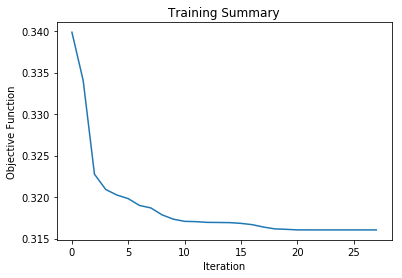

In [30]:
plot_iterations(log_reg_model.summary)

In [31]:
log_reg_model.summary.areaUnderROC


0.6693051266087207

In [32]:
log_reg_model.summary.roc.show(5)


+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|6.567149099542826E-4|0.00964833915373995|
| 0.09276583838984384|0.27416551612117274|
| 0.09325740310054927|0.27559489969950457|
| 0.09465826537888371| 0.2790384146836677|
+--------------------+-------------------+
only showing top 5 rows



In [33]:
def plot_roc_curve(summary):
  roc_curve = summary.roc.toPandas()
  plt.plot(roc_curve["FPR"], roc_curve["FPR"], "k")
  plt.plot(roc_curve["FPR"], roc_curve["TPR"])
  plt.title("ROC Area: %s" % summary.areaUnderROC)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()

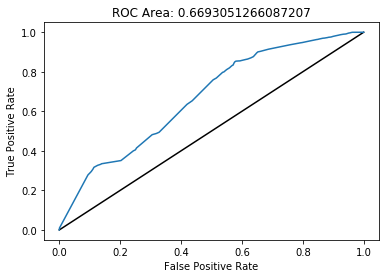

In [34]:
plot_roc_curve(log_reg_model.summary)


### Evaluate the Model

In [35]:
test_summary = log_reg_model.evaluate(test)


In [36]:
type(test_summary)


pyspark.ml.classification.BinaryLogisticRegressionSummary

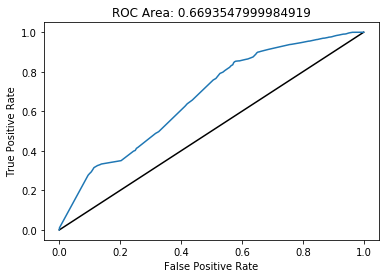

In [37]:
test_summary.areaUnderROC
plot_roc_curve(test_summary)

In [38]:
test_with_prediction = log_reg_model.transform(test)
test_with_prediction.show(5)

+--------+----------------+------+--------------------+--------------------+--------------------+----------+
|SLA_days|dept_name_std_cd|target|            features|       rawPrediction|         probability|prediction|
+--------+----------------+------+--------------------+--------------------+--------------------+----------+
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048570...|[0.73224030160844...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048570...|[0.73224030160844...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048570...|[0.73224030160844...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048570...|[0.73224030160844...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048570...|[0.73224030160844...|       0.0|
+--------+----------------+------+--------------------+--------------------+--------------------+----------+
only showing top 5 

In [39]:
filtered.select('request_address_zip').show()

+-------------------+
|request_address_zip|
+-------------------+
|              78207|
|              78223|
|              78223|
|              78223|
|              78228|
|                   |
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
+-------------------+
only showing top 20 rows



In [40]:
filtered.select('request_address_zip').replace([' ', 'Nan', 'None'], '0', ['request_address_zip']).show()

+-------------------+
|request_address_zip|
+-------------------+
|              78207|
|              78223|
|              78223|
|              78223|
|              78228|
|                   |
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
|              78251|
+-------------------+
only showing top 20 rows



In [41]:
filtered = filtered.na.drop()

In [42]:
filtered.show()

+----------------+--------------------+--------------------+-----------+------+----------+---------+--------+-------------------+
|   dept_division|        request_type|       dept_name_std|case_closed|target|dept_w_SLA|days_late|SLA_days|request_address_zip|
+----------------+--------------------+--------------------+-----------+------+----------+---------+--------+-------------------+
|field operations|        stray animal|animal care services|       true|     0|      true|  -998.51|   999.0|              78207|
|     storm water|removal of obstru...|trans & cap impro...|       true|     0|      true|    -2.01|    4.32|              78223|
|     storm water|removal of obstru...|trans & cap impro...|       true|     0|      true|    -3.02|    4.32|              78223|
|code enforcement|front or side yar...|dsd/code enforcement|       true|     0|      true|   -15.01|   16.29|              78223|
|field operations|animal cruelty(cr...|animal care services|       true|     1|      true|

In [43]:
filtered.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- request_type: string (nullable = true)
 |-- dept_name_std: string (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- target: integer (nullable = false)
 |-- dept_w_SLA: boolean (nullable = true)
 |-- days_late: double (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- request_address_zip: string (nullable = true)



In [44]:
fil_pd = filtered.toPandas()

In [45]:
fil_pd.head()

,dept_division,request_type,dept_name_std,case_closed,target,dept_w_SLA,days_late,SLA_days,request_address_zip
0,field operations,stray animal,animal care services,True,0,True,-998.51,999.00,78207
1,storm water,removal of obstruction,trans & cap improvements,True,0,True,-2.01,4.32,78223
2,storm water,removal of obstruction,trans & cap improvements,True,0,True,-3.02,4.32,78223
3,code enforcement,front or side yard parking,dsd/code enforcement,True,0,True,-15.01,16.29,78223
4,field operations,animal cruelty(critical),animal care services,True,1,True,0.37,0.13,78228


In [46]:
import re
none_test = fil_pd.request_address_zip.replace(to_replace='', value='None', regex=True)
none_test
# none_test.value_counts()

0         78207
1         78223
2         78223
3         78223
4         78228
5          None
6         78251
7         78251
8         78251
9         78251
10        78251
11        78251
12        78251
13        78251
14        78251
15        78251
16        78251
17        78251
18        78251
19        78251
20        78251
21        78251
22        78251
23        78251
24        78251
25        78251
26        78251
27        78251
28        78251
29        78251
          ...  
823560    78251
823561    78252
823562    78209
823563    78221
823564    78237
823565    78220
823566    78217
823567    78216
823568    78251
823569     None
823570    78213
823571    78249
823572    78240
823573    78207
823574    78227
823575    78201
823576    78250
823577    78250
823578     None
823579    78228
823580     None
823581    78240
823582     None
823583    78214
823584    78207
823585     None
823586    78209
823587     None
823588    78249
823589    78218
Name: request_address_zi

In [47]:
filtered = filtered.replace([''], "None", ['request_address_zip'])

### Determine if request_address_zip is a promising feature.

In [48]:
from pyspark.ml.feature import RFormula

rf = RFormula(formula='target ~ request_address_zip')

df2 = rf.fit(filtered).transform(filtered).select('features','target')

In [49]:
df2.show()

+--------------+------+
|      features|target|
+--------------+------+
|(75,[1],[1.0])|     0|
|(75,[8],[1.0])|     0|
|(75,[8],[1.0])|     0|
|(75,[8],[1.0])|     0|
|(75,[2],[1.0])|     1|
|(75,[0],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
|(75,[4],[1.0])|     0|
+--------------+------+
only showing top 20 rows



### Reassemble the feature vector and include request_address_zip.

### Create new train and test datasets.

In [50]:
(train2, test2) = df2.randomSplit([0.6, 0.4], 12345)


### Refit the logistic regression model on the train dataset.

In [51]:
log_reg = LogisticRegression(featuresCol="features", labelCol="target")


In [52]:
log_reg_model2 = log_reg.fit(train2)


In [53]:
log_reg_model2.intercept
log_reg_model2.coefficients

DenseVector([-0.4673, -0.1641, 0.1803, 0.0696, -0.9119, 0.0794, 0.2606, -0.0276, 0.2034, 0.0533, -0.0739, 0.4873, -0.2658, 0.1368, 0.3229, 0.3193, 0.0638, 0.0368, -0.1208, 0.1833, 0.2106, 0.0013, 0.2514, -0.0638, 0.072, -0.1739, 0.3319, 0.3417, 0.2405, -0.0006, 0.0152, -0.1013, 0.0304, 0.0006, 0.2406, 0.3428, 0.1042, 0.2157, 0.6488, 0.2416, -0.037, 0.2186, 0.316, -0.1275, 0.0945, -0.0675, -0.2468, 0.7232, 0.0869, 0.5302, 1.0851, 0.2056, 0.2365, 0.496, 0.5457, 0.3939, 0.2012, 1.084, 0.6428, -0.4192, 1.464, 0.0777, -0.0612, 0.1902, -13.7772, -13.7772, -0.1665, 0.0566, 1.0372, -13.7772, 0.7498, -13.7772, -13.7772, 0.0, -13.7772])

In [54]:
def plot_iterations(summary):
  plt.plot(summary.objectiveHistory)
  plt.title("Training Summary")
  plt.xlabel("Iteration")
  plt.ylabel("Objective Function")
  plt.show()

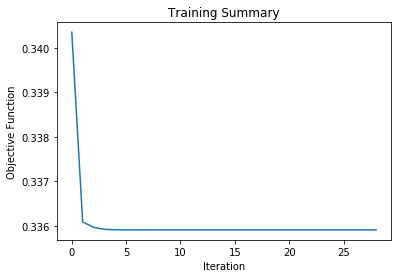

In [55]:
plot_iterations(log_reg_model2.summary)

### Apply the refit logistic model to the test dataset.

In [56]:
log_reg_model3 = log_reg.fit(test2)


### Compute the AUC on the test dataset.

In [57]:
log_reg_model3.summary.areaUnderROC


0.5847181879137835

In [58]:
log_reg_model3.summary.roc.show(5)


+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|1.017708121310808E-4|3.701805341989862...|
|3.595902028631522E-4|0.001252918731135...|
|0.001716534364610...|0.005666609715815251|
|0.001967569034534229|0.006463921635628453|
+--------------------+--------------------+
only showing top 5 rows



In [59]:
def plot_roc_curve(summary):
  roc_curve = summary.roc.toPandas()
  plt.plot(roc_curve["FPR"], roc_curve["FPR"], "k")
  plt.plot(roc_curve["FPR"], roc_curve["TPR"])
  plt.title("ROC Area: %s" % summary.areaUnderROC)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()

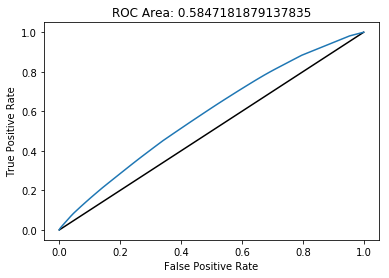

In [60]:
plot_roc_curve(log_reg_model3.summary)


In [61]:
test_summary = log_reg_model2.evaluate(test2)


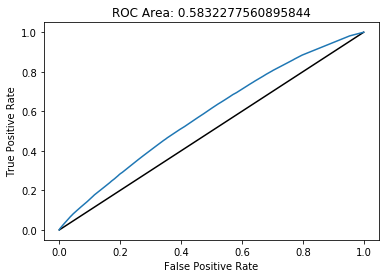

In [62]:
test_summary.areaUnderROC
plot_roc_curve(test_summary)

In [63]:
test_with_prediction = log_reg_model2.transform(test2)
test_with_prediction.show(5)

+--------------+------+--------------------+--------------------+----------+
|      features|target|       rawPrediction|         probability|prediction|
+--------------+------+--------------------+--------------------+----------+
|(75,[0],[1.0])|     0|[2.60338749923081...|[0.93107927540107...|       0.0|
|(75,[0],[1.0])|     0|[2.60338749923081...|[0.93107927540107...|       0.0|
|(75,[0],[1.0])|     0|[2.60338749923081...|[0.93107927540107...|       0.0|
|(75,[0],[1.0])|     0|[2.60338749923081...|[0.93107927540107...|       0.0|
|(75,[0],[1.0])|     0|[2.60338749923081...|[0.93107927540107...|       0.0|
+--------------+------+--------------------+--------------------+----------+
only showing top 5 rows



In [64]:
spark.stop()
